In [1]:
import os
os.chdir("../")

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

/home/mbikandi/miniconda3/envs/ssstsc/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [78]:
from storage.har_datasets import HARTHDataset

In [87]:
ds = HARTHDataset("./datasets/HARTH/", wsize=50, wstride=1)

In [71]:
class UCI_HARDataset:

    def __init__(self,
            dataset_dir: str = None,
            split: str = "train",
            wsize: int = 10,
            wstride: int = 1,
            normalize: bool = True
            ) -> None:
        super().__init__()

        '''
            UCI-HAR dataset handler

            Inputs:
                dataset_dir: Directory of the prepare_har_dataset.py
                    processed dataset.
                wsize: window size
                wstride: window stride
        '''

        self.wsize = wsize
        self.wstride = wstride

        # load dataset
        files = filter(
            lambda x: "sensor.npy" in x,
            os.listdir(os.path.join(dataset_dir, "UCI HAR Dataset", split)))
        
        splits = [0]

        STS = []
        SCS = []
        for f in files:
            sensor_data = np.load(os.path.join(dataset_dir, "UCI HAR Dataset", split, f))
            STS.append(sensor_data)
            SCS.append(np.load(os.path.join(dataset_dir, "UCI HAR Dataset", split, f.replace("sensor", "class"))))

            splits.append(splits[-1] + sensor_data.shape[0])

        self.splits = np.array(splits)

        self.STS = np.concatenate(STS)
        self.SCS = np.concatenate(SCS)

        # normalize with sliding window, not working
        # if normalize:            
        #     means_sw = np.array([np.convolve(self.STS[:,i], np.ones(self.wsize)/self.wsize, mode="same") for i in range(self.STS.shape[1])]).T
        #     means2_sw = np.array([np.convolve(self.STS[:,i]**2, np.ones(self.wsize)/self.wsize, mode="same") for i in range(self.STS.shape[1])]).T
        #     std_sw = (means2_sw - means_sw**2)**.5

        #     self.STS = (self.STS - means_sw) / std_sw

        self.indices = np.arange(self.SCS.shape[0])
        for i in range(wsize * wstride):
            self.indices[self.splits[:-1] + i] = 0
        self.indices = self.indices[np.nonzero(self.indices)]

    def __len__(self):
        return self.indices.shape[0]
    
    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:

        first = self.indices[index]-self.wsize*self.wstride
        last = self.indices[index]

        return self.STS[first:last:self.wstride,:], self.SCS[first:last:self.wstride]
    
    def sliceFromArrayOfIndices(self, indexes: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        assert len(indexes.shape) == 1 # only accept 1-dimensional arrays

        return_sts = np.empty((indexes.shape[0], self.wsize, self.STS.shape[-1]))
        return_scs = np.empty((indexes.shape[0], self.wsize))

        for i, id in enumerate(indexes):
            ts, c = self[id]
            return_scs[i] = c
            return_sts[i] = ts

        return return_sts, return_scs
    
    def getSameClassWindowIndex(self):

        id = []
        cl = []
        for i, ix in enumerate(self.indices):
            if np.unique(self.SCS[(ix-self.wsize*self.wstride):ix]).shape[0] == 1:
                id.append(i)
                cl.append(self.SCS[ix])
        
        return np.array(id), np.array(cl)

In [81]:
ds = UCI_HARDataset("./datasets/UCI-HAR/", split="train", wsize=64, normalize=True)

In [82]:
len(ds)

469248

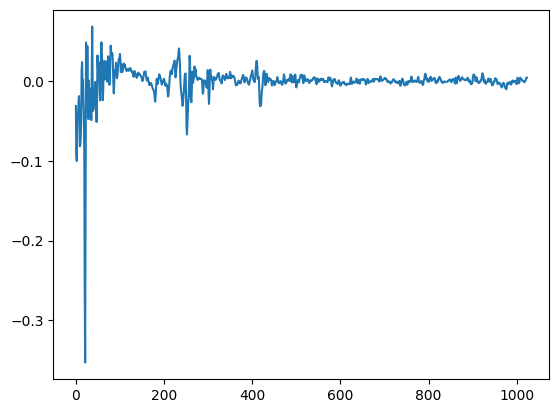

In [5]:
plt.plot(ds.STS[:1024, 0])

In [6]:
ds.STS.shape

(470592, 6)

In [7]:
# TODO scale STS to get mean 0 and std 1

In [75]:
wid, wcl = ds.getSameClassWindowIndex()

In [76]:
def obtain_barycenter(dataset, window_id, window_lb, n_random=100, normalize=False):
    
    np.random.seed(0)

    selected = np.empty((np.unique(window_lb).shape[0], dataset.wsize, dataset.STS.shape[-1]))

    for i, c in enumerate(np.unique(window_lb)):
        # get the random windows for the class c

        rw = np.random.choice(window_id[window_lb == c].reshape(-1), n_random)

        ts, cs = dataset.sliceFromArrayOfIndices(rw)

        km = TimeSeriesKMeans(n_clusters=1, verbose=True, random_state=1, metric="dtw", n_jobs=-1)
        km.fit(ts)

        selected[i] = km.cluster_centers_[0]
    
    return selected

In [77]:
barycenters = obtain_barycenter(ds, wid, wcl, 500)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


43.911 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


32.698 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


32.616 --> 

KeyboardInterrupt: 

In [23]:
from aeon.distances import pairwise_distance

In [24]:
def compute_medoids(
        X: np.ndarray, 
        meds_per_class: int = 1, metric: str = 'dtw', 
    ) -> tuple[np.ndarray, np.ndarray]: 

    """ Computes 'meds_per_class' medoids of each class in the dataset. """

    # X has shape (n, dim, len)

    # Check the distance type
    suported_metrics = ['euclidean', 'squared',
        'dtw', 'ddtw', 'wdtw', 'wddtw', 'lcss', 'edr', 'erp', 'msm']
    if metric not in suported_metrics:
        raise ValueError(f"The distance type must be one of {suported_metrics}.")
    
    sdim, slen = X.shape[1], X.shape[2]

    # Initialize the arrays
    meds = np.empty((meds_per_class, sdim, slen), dtype=float)
    meds_idx = np.empty((meds_per_class), dtype=int)
    
    # Find the medoids
    dm = pairwise_distance(X, metric=metric)
    scores = dm.sum(axis=0)
    meds_idx = np.argpartition(scores, meds_per_class)[:meds_per_class]
    meds[:,:,:] = X[meds_idx]

    # Return the medoids and their indices
    return meds, meds_idx

In [32]:
def obtain_medoids(dataset, window_id, window_lb, n_random=100, normalize=False):
    
    np.random.seed(0)

    selected = np.empty((np.unique(window_lb).shape[0], dataset.wsize, dataset.STS.shape[-1]))

    for i, c in enumerate(np.unique(window_lb)):
        # get the random windows for the class c

        rw = np.random.choice(window_id[window_lb == c].reshape(-1), n_random)

        ts, cs = dataset.ts_from_array(rw)

        med = compute_medoids(np.transpose(ts, (0, 2, 1)))[0]

        selected[i] = med[0].T
    
    return selected

In [33]:
meds = obtain_medoids(ds, wid, wcl, 500)

[[<matplotlib.lines.Line2D at 0x7f7c57c4e140>],

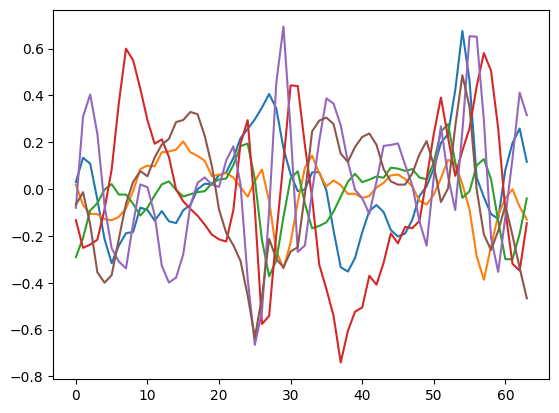

In [41]:
fig, ax = plt.subplots(nrows=1)
[ax.plot(meds[0,:,d]) for d in range(6)]

In [12]:
from s3ts.api.encodings import compute_DM

In [13]:
class UCI_HARDataset_DM(UCI_HARDataset):

    def __init__(self,
            dataset_dir: str = None,
            split: str = "train",
            wsize: int = 10,
            wstride: int = 1,
            patterns: np.ndarray = None,
            w: float = 0.2,
            normalize: bool = True
            ) -> None:
        super().__init__(dataset_dir=dataset_dir, split=split, wsize=wsize, wstride=wstride, normalize=normalize)

        '''
            UCI-HAR dataset handler, with DF computation

            Inputs:
                dataset_dir: Directory of the prepare_har_dataset.py
                    processed dataset.
                wsize: window size
                wstride: window stride
                patterns: patterns used for DF computation
                w: online dtw forgetting parameter
        '''

        assert patterns.shape[1] == wsize

        self.rho = w

        # compute and save DM to disk, one per split
        if not os.path.exists(os.path.join(dataset_dir, "cached_df")):
            os.mkdir(os.path.join(dataset_dir, "cached_df"))

        self.cache_dir = os.path.join(dataset_dir, "cached_df")
        self.split = split
        self.patterns = patterns

        for s in range(self.splits.shape[0] - 1):
            save_path = os.path.join(dataset_dir, f"cached_df/{split}_split{s}.npy")
            self._compute_dm_cache(patterns, self.splits[s:s+2], save_path)

        self.loaded_split = None
        self.temp = None

    def _compute_dm_cache(self, pattern, split, save_path):
        DM = compute_DM(self.STS[split[0]:split[1]].T, pattern.transpose(0, 2, 1), rho=self.rho)

        with open(save_path, "wb") as f:
            np.save(f, DM.transpose((0, 2, 1)))

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray, int]:

        id = self.indices[index]

        # identify the split of the index

        s = np.argwhere(self.splits > id)[0, 0] - 1
        first = id - self.wsize*self.wstride - self.splits[s]
        last = id - self.splits[s]

        if self.loaded_split != s:
            self.temp = np.load(os.path.join(self.cache_dir, f"{self.split}_split{s}.npy"))
            self.loaded_split = s

        return self.temp[:, first:last:self.wstride, :], self.STS[first:last:self.wstride, :], self.SCS[id]

In [42]:
ds_df = UCI_HARDataset_DM("./datasets/UCI-HAR/", split="train", wsize=64, patterns=meds, wstride=1, normalize=True)

In [43]:
from IPython.display import display, clear_output

In [44]:
from time import time

In [45]:
a=time()
for i in range(1000):
    ds_df[i]
    print(f"\r{i}: {(i+1)/(time()-a)} per/s", end="", flush=True)

155: 2224.225117702048 per/ss

999: 2497.247213723028 per/ss

In [46]:
len(ds_df)

469248

In [47]:
from storage.label_mappings import UCI_HAR_LABELS

In [52]:
UCI_HAR_LABELS

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

KeyboardInterrupt: 

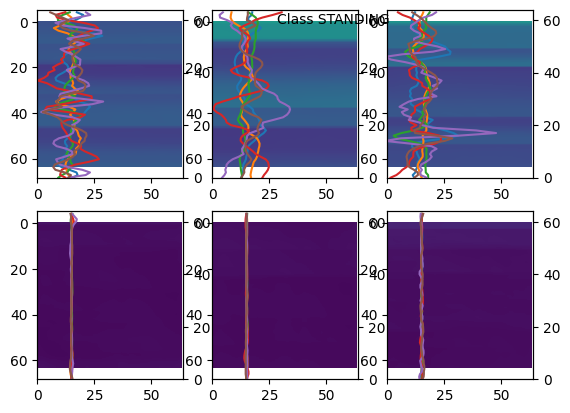

In [70]:
plot, ax = plt.subplots(nrows=2, ncols=3)

title = plot.text(0.5,0.85, "")

ax_images = []
for i in range(2):
    for j in range(3):
        if i==0:
            ax_images.append(ax[i, j].imshow(np.random.randn(64, 64), vmin=0, vmax=100))
        if i==1:
            ax_images.append(ax[i, j].imshow(np.random.randn(64, 64), vmin=0, vmax=50))

        ax_twin = ax[i, j].twinx()
        ax_twin.set_xlim([0, 64])
        ax_twin.set_ylim([0, 64])
        [ax_twin.plot(meds[i*3+j,:,h]*20 + 15, np.arange(64)) for h in range(6)]

for i in range(0, 20000, 16):
    for col in range(3):
        df, ts, c = ds_df[i]
        for h in range(6):
            ax_images[h].set_data(df[h].T)

    title.set_text(f"Class {UCI_HAR_LABELS[c]}")
    display(plot)    
    clear_output(wait = True)